In [7]:
import os
import time
import numpy as np
import pandas as pd
from collections import defaultdict, Counter

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from skimage.transform import resize
from imageio import imread

from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
init_notebook_mode(connected=True)

In [8]:
class LogRegression():
    def __init__(self, lr=0.01, batch_size=10, max_iterations=1000, min_profit_step=0.001):
        self.lr = lr
        self.batch_size = batch_size
        self.max_iterations = max_iterations
        self.W = None
        
    def get_cost(self, X, y):
        return np.mean(np.log(1 + np.exp(-y * np.dot(X, self.W).flatten())))
    
    def fit(self, X_train, y_train, X_val, y_val):
        # Here we add the fake column to simplify calculations
        X_ = np.concatenate((np.ones([X_train.shape[0], 1]), X_train), axis=1)
        X_val_ = np.concatenate((np.ones([X_val.shape[0], 1]), X_val), axis=1)
        self.W = np.ones([X.shape[1]+1, 1]) * 0.0001
        iterations = 0
        accuracy_v = []
        n = X_.shape[0]
        previous_cost = None
        
        while(iterations < self.max_iterations):
            sample_ids = np.random.randint(0, n, self.batch_size)
            sample_X = X_[sample_ids, :]
            sample_y = y_train[sample_ids]
            cost_v = []
            for i in range(self.batch_size):
                exp = 1 + np.exp(sample_y[i] * np.dot(self.W.flatten(), sample_X[i, :]))
                cost_v.append((sample_X[i, :] * sample_y[i]) / exp)
            previous_W = self.W
            self.W = self.W + self.lr * (np.sum(np.array(cost_v), axis=0).reshape(self.W.shape))
            cost = self.get_cost(X_val_, y_val)
            if previous_cost:
                cost_diff = previous_cost - cost
                if (cost_diff < 0) or (cost_diff < min_profit_step*previous_cost):
                    self.W = previous_W
                    break
            previous_cost = cost
            accuracy_v.append(accuracy_score(self.predict(X_val), y_val))
            iterations += 1
        return accuracy_v
    
    def predict(self, X):
        X_ = np.concatenate((np.ones([X.shape[0], 1]), X), axis=1)
        predictions_0_1 = 1 / (1 + np.exp(-1 * np.dot(X_, self.W)))
        return [1 if p > 0.5 else -1 for p in predictions_0_1]

### Task 1 - Logistic regression

Spam dataset

In [4]:
df = pd.read_csv('../data/spam.csv')
df.label = df.label.map(lambda y: y if y == 1 else -1)
X = df[df.columns.difference(['label'])].values
y = df.label.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

Library algorithm

In [5]:
lib_logr = LogisticRegression(solver='liblinear', random_state=42)
lib_logr.fit(X_train, y_train)
print(f"Accuracy: {accuracy_score(lib_logr.predict(X_val), y_val)}")

Accuracy: 0.9185667752442996


Realized algorithm

In [10]:
lr=0.001
batch_size=16
min_profit_step=0.0001
logr = LogRegression(lr=lr, batch_size=batch_size, max_iterations=100, min_profit_step=min_profit_step)
accuracy_v = logr.fit(X_train, y_train, X_val, y_val)
print(f"Accuracy: {accuracy_score(logr.predict(X_val), y_val)}")
trace = go.Scatter(x=np.arange(len(accuracy_v)), y=accuracy_v)
fig = go.Figure(data=[trace], layout=go.Layout(title=f'Accuracy (lr={lr}, batch_size={batch_size}, min_profit_step={min_profit_step})'))
fig.update_xaxes(title_text="Iteration")
fig.update_yaxes(title_text="Accuracy")
iplot(fig)

Accuracy: 0.9022801302931596


Cancer dataset

In [11]:
cancer_df = pd.read_csv('../data/cancer.csv')
cancer_df['int_label'] = cancer_df.label.map({'M':1, 'B':-1})
cancer_df['label'] = cancer_df.int_label
cancer_df.drop('int_label', axis=1, inplace=True)
X = cancer_df[cancer_df.columns.difference(['label'])].values
y = cancer_df.label.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

Library algorithm

In [12]:
lib_logr = LogisticRegression(solver='liblinear', random_state=42)
lib_logr.fit(X_train, y_train)
print(f"Accuracy: {accuracy_score(lib_logr.predict(X_val), y_val)}")

Accuracy: 0.9736842105263158


Realized algorithm

In [14]:
lr=0.001
batch_size=16
min_profit_step=0.0001
logr = LogRegression(lr=lr, batch_size=batch_size, max_iterations=100, min_profit_step=min_profit_step)
accuracy_v = logr.fit(X_train, y_train, X_val, y_val)
print(f"Accuracy: {accuracy_score(logr.predict(X_val), y_val)}")
trace = go.Scatter(x=np.arange(len(accuracy_v)), y=accuracy_v)
fig = go.Figure(data=[trace], layout=go.Layout(title=f'Accuracy (lr={lr}, batch_size={batch_size}, min_profit_step={min_profit_step})'))
fig.update_xaxes(title_text="Iteration")
fig.update_yaxes(title_text="Accuracy")
iplot(fig)

Accuracy: 0.9736842105263158


### Task 2 - Images visualization
This task is made just as an example. In other tasks datasets are loaded with the special loaders

MNIST

In [37]:
def features2matrix(features):
    image_size = int(np.sqrt(features.flatten().shape[0]))
    return features.reshape([image_size, image_size])

Text(0.5, 0.98, 'MNIST examples')

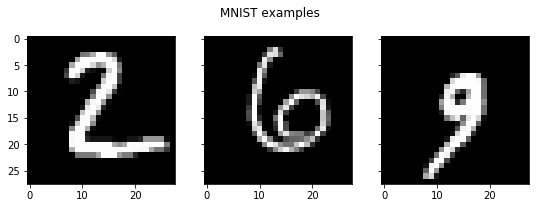

In [39]:
df_mnist = pd.read_csv("../data/mnist.csv")
X = df_mnist.loc[:,df_mnist.columns != "label"].values   #Normalizing the values
y = df_mnist.label.values

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].imshow(features2matrix(X[1, :]), cmap='gray')
axs[1].imshow(features2matrix(X[100, :]), cmap='gray')
axs[2].imshow(features2matrix(X[1000, :]), cmap='gray')
fig.suptitle('MNIST examples')

Not MNIST

In [2]:
pic1 = np.array(Image.open("../data/notMNIST_small/A/MDEtMDEtMDAudHRm.png"))
pic2 = np.array(Image.open("../data/notMNIST_small/D/SVRDIFVzaGVyd29vZCBNZWRpdW0ucGZi.png"))
pic3 = np.array(Image.open("../data/notMNIST_small/I/SWFkZWxvbi1Cb2xkLm90Zg==.png"))
print(f"Shapes of pictures: {pic1.shape}, {pic2.shape}, {pic3.shape}")

Shapes of pictures: (28, 28), (28, 28), (28, 28)


Text(0.5, 0.98, 'notMNIST examples')

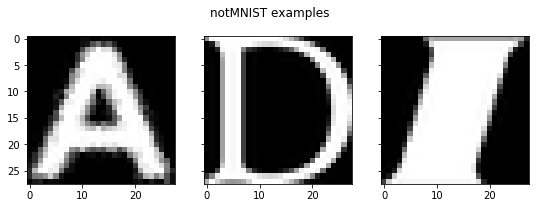

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].imshow(pic1, cmap='gray')
axs[1].imshow(pic2, cmap='gray')
axs[2].imshow(pic3, cmap='gray')
fig.suptitle('notMNIST examples')

### Task 3 - MNIST (Sigmoid, Tanh, ReLU)

In [8]:
# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Print(nn.Module):
    def forward(self, x):
        print(x.size())
        return x

MNIST

In [15]:
df_mnist = pd.read_csv("./data/mnist.csv")

X = df_mnist.loc[:, df_mnist.columns != "label"].values/255   #Normalizing the values
y = df_mnist.label.values

features_train, features_test, targets_train, targets_test = train_test_split(X, y, test_size=0.2,
                                                                              random_state=42)
X_train = torch.from_numpy(features_train)
X_test = torch.from_numpy(features_test)
y_train = torch.from_numpy(targets_train).type(torch.LongTensor)
y_test = torch.from_numpy(targets_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)

train_batch_size = 64
test_batch_size = 64
train_loader = torch.utils.data.DataLoader(train, batch_size=train_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch_size, shuffle=False)

In [30]:
def get_activation_layer(activation):
    if activation == 'relu':
        return nn.ReLU()
    if activation == 'tanh':
        return nn.Tanh()
    if activation == 'sigmoid':
        return nn.LogSigmoid()
    raise Exception(f"unknown activation: {activation}")
    
def MNIST_model_creation(activation='relu'):
    model = nn.Sequential()
    model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1))
    model.add_module('a1', get_activation_layer(activation))
    model.add_module('conv2', nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1))
    model.add_module('a2', get_activation_layer(activation))
    model.add_module('conv3', nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1))
    model.add_module('a3', get_activation_layer(activation))
    model.add_module('flatten', Flatten())
    model.add_module('dense1', nn.Linear(6272, 64))
    model.add_module('a4', get_activation_layer(activation))
    model.add_module('dense2', nn.Linear(64, 64))
    model.add_module('a5', get_activation_layer(activation))
    model.add_module('out', nn.Linear(64, 10))
    model = model.double()
    return model
    
def train_MNIST(train_loader, test_loader, activation='relu', epochs=10):
    model = MNIST_model_creation(activation)
    crit = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        running_loss = 0
        model.train()
        for images, labels in train_loader:
            train = Variable(images.view(-1,1,28,28))
            labels = Variable(labels)

            opt.zero_grad()

            output = model(train.double())
            loss = crit(output, labels)
            loss.backward()
            opt.step()
            running_loss += loss.item()

        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                test = Variable(images.view(-1,1,28,28))
                labels = Variable(labels)

                log_ps = model(test)
                test_loss += crit(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Sigmoid (just LogSigmoid worked)

In [31]:
train_MNIST(train_loader, test_loader, activation='sigmoid', epochs=10)

Epoch: 1/10..  Training Loss: 2.313..  Test Loss: 2.303..  Test Accuracy: 0.108
Epoch: 2/10..  Training Loss: 2.271..  Test Loss: 1.838..  Test Accuracy: 0.349
Epoch: 3/10..  Training Loss: 0.800..  Test Loss: 0.527..  Test Accuracy: 0.831
Epoch: 4/10..  Training Loss: 0.478..  Test Loss: 0.433..  Test Accuracy: 0.868
Epoch: 5/10..  Training Loss: 0.389..  Test Loss: 0.369..  Test Accuracy: 0.887
Epoch: 6/10..  Training Loss: 0.303..  Test Loss: 0.320..  Test Accuracy: 0.907
Epoch: 7/10..  Training Loss: 0.234..  Test Loss: 0.261..  Test Accuracy: 0.927
Epoch: 8/10..  Training Loss: 0.191..  Test Loss: 0.237..  Test Accuracy: 0.935
Epoch: 9/10..  Training Loss: 0.160..  Test Loss: 0.235..  Test Accuracy: 0.936
Epoch: 10/10..  Training Loss: 0.136..  Test Loss: 0.235..  Test Accuracy: 0.930


Tanh

In [26]:
train_MNIST(train_loader, test_loader, activation='tanh', epochs=10)

Epoch: 1/10..  Training Loss: 0.828..  Test Loss: 0.344..  Test Accuracy: 0.914
Epoch: 2/10..  Training Loss: 0.287..  Test Loss: 0.256..  Test Accuracy: 0.929
Epoch: 3/10..  Training Loss: 0.196..  Test Loss: 0.216..  Test Accuracy: 0.939
Epoch: 4/10..  Training Loss: 0.143..  Test Loss: 0.192..  Test Accuracy: 0.946
Epoch: 5/10..  Training Loss: 0.105..  Test Loss: 0.184..  Test Accuracy: 0.950
Epoch: 6/10..  Training Loss: 0.077..  Test Loss: 0.183..  Test Accuracy: 0.952
Epoch: 7/10..  Training Loss: 0.056..  Test Loss: 0.165..  Test Accuracy: 0.954
Epoch: 8/10..  Training Loss: 0.042..  Test Loss: 0.168..  Test Accuracy: 0.954
Epoch: 9/10..  Training Loss: 0.032..  Test Loss: 0.168..  Test Accuracy: 0.954
Epoch: 10/10..  Training Loss: 0.020..  Test Loss: 0.171..  Test Accuracy: 0.954


ReLU

In [27]:
train_MNIST(train_loader, test_loader, activation='relu', epochs=10)

Epoch: 1/10..  Training Loss: 0.993..  Test Loss: 0.354..  Test Accuracy: 0.893
Epoch: 2/10..  Training Loss: 0.287..  Test Loss: 0.275..  Test Accuracy: 0.913
Epoch: 3/10..  Training Loss: 0.201..  Test Loss: 0.223..  Test Accuracy: 0.933
Epoch: 4/10..  Training Loss: 0.140..  Test Loss: 0.191..  Test Accuracy: 0.947
Epoch: 5/10..  Training Loss: 0.104..  Test Loss: 0.195..  Test Accuracy: 0.953
Epoch: 6/10..  Training Loss: 0.078..  Test Loss: 0.186..  Test Accuracy: 0.955
Epoch: 7/10..  Training Loss: 0.056..  Test Loss: 0.184..  Test Accuracy: 0.959
Epoch: 8/10..  Training Loss: 0.041..  Test Loss: 0.197..  Test Accuracy: 0.955
Epoch: 9/10..  Training Loss: 0.031..  Test Loss: 0.194..  Test Accuracy: 0.958
Epoch: 10/10..  Training Loss: 0.035..  Test Loss: 0.178..  Test Accuracy: 0.960


### Task 4 - notMNIST

In [39]:
def load_notmnist(path, letters, img_shape=(28,28),
                  test_size=0.20, one_hot=False):
    data, labels = [], []
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters:
            continue
        try:
            data.append(resize(imread(img_path), img_shape))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)

    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    # convert classes to ints
    letter_to_i = {l: i for i, l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))

    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None, :] == labels[:, None]).astype('float32')

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42)

    print("Done")
    return X_train, y_train, X_test, y_test

In [40]:
features_train, targets_train, features_test, targets_test = load_notmnist(
    path='./notMNIST_small', letters='ABCDEFGHIJ')
X_train = torch.from_numpy(features_train)
X_test = torch.from_numpy(features_test)
y_train = torch.from_numpy(targets_train).type(torch.LongTensor)
y_test = torch.from_numpy(targets_test).type(torch.LongTensor)
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [41]:
train_batch_size = 4
test_batch_size = 4
train_loader = torch.utils.data.DataLoader(train, batch_size=train_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch_size, shuffle=False)

In [42]:
def NotMNIST_model_creation():
    model = nn.Sequential()
    model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1))
    model.add_module('a1', nn.ReLU())
    model.add_module('conv2', nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1))
    model.add_module('a2', nn.ReLU())
    model.add_module('conv3', nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1))
    model.add_module('a3', nn.ReLU())
    model.add_module('flatten', Flatten())
    model.add_module('dense1', nn.Linear(6272, 64))
    model.add_module('a4', nn.ReLU())
    model.add_module('dense2', nn.Linear(64, 64))
    model.add_module('a5', nn.ReLU())
    model.add_module('out', nn.Linear(64, 10))
    model = model.float()
    return model
    
def train_notMNIST(train_loader, test_loader, epochs=10):
    model = NotMNIST_model_creation()
    crit = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        running_loss = 0
        model.train()
        for images, labels in train_loader:
            train = Variable(images.view(-1,1,28,28))
            labels = Variable(labels)

            opt.zero_grad()

            output = model(train.float())
            loss = crit(output, labels)
            loss.backward()
            opt.step()
            running_loss += loss.item()

        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                test = Variable(images.view(-1,1,28,28))
                labels = Variable(labels)

                log_ps = model(test.float())
                test_loss += crit(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
    return model

In [43]:
model = train_notMNIST(train_loader, test_loader, epochs=5)

Epoch: 1/5..  Training Loss: 0.414..  Test Loss: 0.307..  Test Accuracy: 0.904
Epoch: 2/5..  Training Loss: 0.232..  Test Loss: 0.274..  Test Accuracy: 0.918
Epoch: 3/5..  Training Loss: 0.179..  Test Loss: 0.296..  Test Accuracy: 0.913
Epoch: 4/5..  Training Loss: 0.133..  Test Loss: 0.322..  Test Accuracy: 0.918
Epoch: 5/5..  Training Loss: 0.112..  Test Loss: 0.340..  Test Accuracy: 0.922
